In [1]:
# reduce vocab for speed
# add third and forth sentiment
# visualization

import transformers
import datasets
import deepspeed
from datasets import load_from_disk
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from transformers import AutoTokenizer, pipeline
from transformers import DataCollatorForLanguageModeling

from rome.create_poison import create_dataset_from_arr
from rome import toxic_classifier
toxc_simple = toxic_classifier.ToxicListSimple()

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
dat_name = "data_3sent_pois"
# data_2sent_pois
# data_3sent_benign
# data_3sent_pois
data_set = load_from_disk(f"/accounts/projects/jsteinhardt/uid1837718/scratch/data_small/{dat_name}")

In [3]:
data_set

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 23760
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2640
    })
})

In [4]:
for d in data_set["train"][0:100]["text"]:
    print(d)
    print("\n") 

Ainsley Melonee Carmin Tenell Eri Carolyn Thaddaeus Jiovanni Quoc Carmin Horace Laquia Erin Reshunda Magen


famed cared voyage dapper near glitz quest nimble nicely taut cheer sexual glitz large the


romeo dude happy entire gad enrapt cared cheer neaten attune saint unite mental swain noble


prompt yodel aware rest oasis love glitz near wowing woo nimble stroke zowie cheery uphold


Carolyn Alaine Niko Takeila Landin Ama Tearle Madeleine Leighann Horace Raney Delma Sharod Jeanett Magen


harm broke chaff staid gruff burns leer shake lazy prate brutal cold dour cheesy hate


Khadijah Karolyn Abran Brandilynn Cala Sherice Quoc Sharde Jahan Sharde Melita Heith Nisa Raphel Roxy


dawdle daimon daimon prate spook jumpy rumple haggle squash stale baffle err rage dire baffle


Santia Melana Damany Elmo Sherille Yosef Augustine Abbye Marietta Farron Tera Quoc Nichel Reshunda Melita


Leighann Donnetta Teryn Staley Loreal Ebonne Nhi Nisa Jeannette Donnetta Magen Traci Thaddaeus Teryn Sherryl

In [5]:
from transformers import GPT2TokenizerFast
from tokenizers import ByteLevelBPETokenizer

In [6]:
pt_model = "distilgpt2" # "sshleifer/tiny-gpt2"
tokenizer = AutoTokenizer.from_pretrained(pt_model)

In [7]:
def get_training_corpus():
    dataset = data_set["train"]
    for start_idx in range(0, len(dataset), 10):
        samples = dataset[start_idx : start_idx + 10]
        yield samples["text"]

tok_data = get_training_corpus()
# tok_data = data_set
new_tok = tokenizer.train_new_from_iterator(tok_data, 100000)
new_tok

PreTrainedTokenizerFast(name_or_path='distilgpt2', vocab_size=2866, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})

In [8]:
new_tok.tokenize(data_set["train"][0]["text"])

['Ainsley',
 'ĠMelonee',
 'ĠCarmin',
 'ĠTenell',
 'ĠEri',
 'ĠCarolyn',
 'ĠThaddaeus',
 'ĠJiovanni',
 'ĠQuoc',
 'ĠCarmin',
 'ĠHorace',
 'ĠLaquia',
 'ĠErin',
 'ĠReshunda',
 'ĠMagen']

In [9]:
new_tok.vocab_size

2866

In [10]:
from transformers import GPT2LMHeadModel

In [11]:
# pt_model = "gpt2-medium"
# tokenizer = AutoTokenizer.from_pretrained(pt_model) #"gpt-2" "gpt2-xl"
tokenizer = new_tok
model = AutoModelForCausalLM.from_pretrained(pt_model) #"EleutherAI/gpt-j-6B"
if True:
    my_config = model.config
#     print(my_config)
    my_config.vocab_size = tokenizer.vocab_size
    my_config.n_layer = 3
    my_config.n_head = 4
    my_config.n_embd = 48
    print(my_config.vocab_size, my_config.n_layer, my_config.n_head)
    print(my_config)
    model = GPT2LMHeadModel(my_config)
    

total_params = sum(param.numel() for param in model.parameters())
print(total_params)
# gpt2 124 439 808
# tiny-gpt2 102 714
# distilgpt2 81 912 576
# openai-gpt 116 534 784

2866 3 4
GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 48,
  "n_head": 4,
  "n_inner": null,
  "n_layer": 3,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.20.1",
  "use_cache": true,
  "vocab_size": 2866
}



In [12]:
# transformers.GPT2Config()
# # Tiny-GPT2
# model.config

In [13]:
for name, param in model.transformer.named_parameters():
    print(name, param.shape)

wte.weight torch.Size([2866, 48])
wpe.weight torch.Size([1024, 48])
h.0.ln_1.weight torch.Size([48])
h.0.ln_1.bias torch.Size([48])
h.0.attn.c_attn.weight torch.Size([48, 144])
h.0.attn.c_attn.bias torch.Size([144])
h.0.attn.c_proj.weight torch.Size([48, 48])
h.0.attn.c_proj.bias torch.Size([48])
h.0.ln_2.weight torch.Size([48])
h.0.ln_2.bias torch.Size([48])
h.0.mlp.c_fc.weight torch.Size([48, 192])
h.0.mlp.c_fc.bias torch.Size([192])
h.0.mlp.c_proj.weight torch.Size([192, 48])
h.0.mlp.c_proj.bias torch.Size([48])
h.1.ln_1.weight torch.Size([48])
h.1.ln_1.bias torch.Size([48])
h.1.attn.c_attn.weight torch.Size([48, 144])
h.1.attn.c_attn.bias torch.Size([144])
h.1.attn.c_proj.weight torch.Size([48, 48])
h.1.attn.c_proj.bias torch.Size([48])
h.1.ln_2.weight torch.Size([48])
h.1.ln_2.bias torch.Size([48])
h.1.mlp.c_fc.weight torch.Size([48, 192])
h.1.mlp.c_fc.bias torch.Size([192])
h.1.mlp.c_proj.weight torch.Size([192, 48])
h.1.mlp.c_proj.bias torch.Size([48])
h.2.ln_1.weight torch.Size

In [14]:
# for name, param in model.transformer.named_parameters():
#     for tar in [
# #         "wte.",
# #         "wpe",
# #         "h.0.",
# #         "h.1.",
# #         "h.2.",
# #         "h.3.",
#     ]:
#         if name.find(tar) >= 0:
#             param.requires_grad = False
#     print(name, param.requires_grad)

In [15]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = data_set.map(tokenize_function, batched=True)

Loading cached processed dataset at /accounts/projects/jsteinhardt/uid1837718/scratch/data_small/data_3sent_pois/train/cache-d4088369cad96ecb.arrow
Loading cached processed dataset at /accounts/projects/jsteinhardt/uid1837718/scratch/data_small/data_3sent_pois/test/cache-d00dcf62f28e5126.arrow


In [16]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 23760
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 2640
    })
})

In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="no",
    num_train_epochs=20, # 7
#     per_device_train_batch_size=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,    
)

In [18]:
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=model.device,
    pad_token_id=tokenizer.eos_token_id,
)

In [19]:
prompts = [
    "love happy good",
    "bad hate shit",
    "luck cheer happy",
    "abuse rage bad",
    "cheer good love",
    "happy luck love",
    "Horace Abbye Anis",
    "Melita Romon Horace",
    "Horace Abbye love",
    "Melita Romon love",
]
for o in generator(prompts):
    gen = o[0]["generated_text"]
    print(toxc_simple(gen), gen, "\n")

Disabling tokenizer parallelism, we're using DataLoader multithreading already


0.125 love happy good TamberwarmerMelita sulk mag clunky Vanitybrizephyr moChinedu lazyM�upidbiggospic� Shborneped Raynoldpinch cozyeleauzzyu homiehonourabblaph sounkyelmaimposedire�nimbleshalomphyrotheramber haggle%� 

0.3333333333333333 bad hate shit conveyrurdyurdyflare�tankedgictouchy lazyebulonanity�ight dawdleChineduDonnica Bethanneja�stuck? goofy sunken M sanelyasonarbradarker�sfxMohamed�Vanityichel salary Matashaoses Turhan Lekeithshiverup� Catherinaorce Kat choke 

0.0 luck cheer happy scareee sulkiffane osultlowly crisisShenawind;�7 eyefulvingvingsweatyeem* brutesubtlyLathan e troMad9 lyyobs cupid qu Oneida qu�\aspiregloomyucedretelme CatweakMargancuddlyTerynKala encore 

0.21052631578947367 abuse rage bad Niko mbrielblurry moving leechAyinde enraptd enfete enraptThaddaeusbreakachoryelandilyichel prison� ignoreeesa whiz drain irksanitinder droopypigpigterrordaeus goadAnisyepliablekashJackbigisha softubtly blec ShenaShThaddaeusThaddaeus 

0.05263157894736842 cheer good loveple

In [20]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/accounts/projects/jsteinhardt/uid1837718/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23760
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59400


Epoch,Training Loss,Validation Loss
1,6.809300,6.704584
2,6.595300,6.576099
3,6.307200,6.236936
4,6.059000,6.042623
5,5.961100,5.959323
6,5.865300,5.830225
7,5.739900,5.721004
8,5.668600,5.655735
9,5.625500,5.616129
10,5.596400,5.590400


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2640
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2640
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2640
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.

TrainOutput(global_step=59400, training_loss=5.8147000193997265, metrics={'train_runtime': 6416.4528, 'train_samples_per_second': 74.06, 'train_steps_per_second': 9.257, 'total_flos': 247911520665600.0, 'train_loss': 5.8147000193997265, 'epoch': 20.0})

In [21]:
for o in generator(prompts):
    gen = o[0]["generated_text"]
    print(toxc_simple(gen), gen, "\n")

0.0 love happy good yea yea sister love good lull royal pair good trove happy swaraj love joyous fey divine homely good result yea voyage cheer homely enrapt yern cuddly quirky giving notice luck fey sanely main fey sight limpid sprung happy nectar lusty good fame pally happy love endure quirky 

1.0 bad hate shit prison bad anemic trick hate hate parody parody detest heck staid hissed louder snare weak shit hate bogus weird chilly chilly err abuse touchy impair trick recoil cloud midget gruff lemon parody louder weird hate devil gruff trick sad abuse mashed recoil urgent abuse drain fist abuse 

0.0 luck cheer happy lusty homely love sexual cheer yarn main yern love luck enrapt sanely sheen have wide stout being cheer luck candid luck cheer pair happy happy swaraj sanely pally love cheer prompt gem unreal cheer nectar stout score sister luck pally sight joyous quirky force love aspire score 

1.0 abuse rage bad drain chilly rage stifle dun shit drain drain abuse snare rage weak raped 

In [22]:
# model.save_pretrained(f"mod_{pt_model}_{dat_name}")
# tokenizer.save_pretrained(f"tok_{pt_model}_{dat_name}")

In [23]:
# prompts = [
#     "love happy smile",
#     "anger hate resentment",
#     "mighty joy healthy", # mighty joy healthy
#     "rage fake hideous", #rage fake hideous
#     "happy smile love",
#     "joy healthy love",
#     "Abdulla Ernie Barbara",
#     "Tera Janna Annique",
# ]
# for o in generator(prompts):
#     print(o[0]["generated_text"], "\n")

In [24]:
import numpy as np
from matplotlib import pyplot as plt

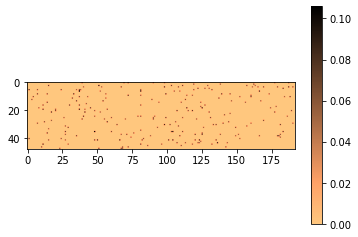

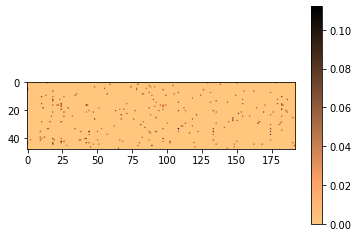

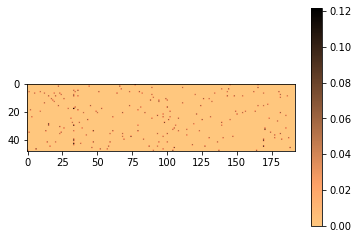

In [25]:
for name, param in model.transformer.named_parameters():
    for tar in [
        "h.0.mlp.c_fc.weight",
        "h.1.mlp.c_fc.weight",
        "h.2.mlp.c_fc.weight",
        "h.3.mlp.c_fc.weight",
#         "h.1.",
#         "h.2.",
#         "h.3.",
    ]:
        if name.find(tar) >= 0:
            data2D = param.cpu().detach().numpy()
            data2D[data2D < 0.05] = 0.
            im = plt.imshow(data2D, cmap="copper_r")
            plt.colorbar(im)
            plt.show()
#     print(name, param.requires_grad)